In [1]:
import time
print(time.localtime())

time.struct_time(tm_year=2017, tm_mon=11, tm_mday=17, tm_hour=12, tm_min=50, tm_sec=8, tm_wday=4, tm_yday=321, tm_isdst=0)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import scipy.signal as sig
import control as con
from statsmodels.tsa.arima_model import ARIMA
import warnings
%pylab inline
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/home/ipa325/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


###### Reading all the data

In [3]:
#data1
df_soll_1 = pd.read_csv('step_log/2017-11-03_ext_topic_logger/2017-11-03_14-25-18_control_output.log',
                 header=0,
                 names=['time', 'x_soll'])
df_soll_1 = df_soll_1.set_index('time')
df_soll_1 = df_soll_1[~df_soll_1.index.duplicated(keep='first')] #gets rid of any duplicate values if present
df_ist_1 = pd.read_csv('step_log/2017-11-03_ext_topic_logger/2017-11-03_14-25-19_task_vel.log',
                 header=0,
                 names=['time', 'x_ist'])
df_ist_1 = df_ist_1.set_index('time')
df_ist_1 = df_ist_1[~df_ist_1.index.duplicated(keep='first')]
df_ist_soll_1 = pd.concat([df_soll_1.x_soll, df_ist_1.x_ist], axis=1).fillna(method='pad')
df_ist_soll_1 = df_ist_soll_1.fillna(0)
#df_ist_soll_1.plot(style='-', drawstyle="steps")
#data2
df_soll_2 = pd.read_csv('step_log/2017-11-03_ext_topic_logger/2017-11-03_14-26-43_control_output.log',
                 header=0,
                 names=['time', 'x_soll'])
df_soll_2 = df_soll_2.set_index('time')
df_ist_2 = pd.read_csv('step_log/2017-11-03_ext_topic_logger/2017-11-03_14-26-43_task_vel.log',
                 header=0,
                 names=['time', 'x_ist'])
df_ist_2 = df_ist_2.set_index('time')
df_ist_2 = df_ist_2[~df_ist_2.index.duplicated(keep='first')]
df_ist_soll_2 = pd.concat([df_soll_2.x_soll, df_ist_2.x_ist], axis=1).fillna(method='pad')
df_ist_soll_2 = df_ist_soll_2.fillna(0)
#df_ist_soll_2.plot(style='-', drawstyle="steps")
#data3
df_soll_3 = pd.read_csv('step_log/2017-11-03_ext_topic_logger/2017-11-03_14-27-47_control_output.log',
                 header=0,
                 names=['time', 'x_soll'])
df_soll_3 = df_soll_3.set_index('time')
df_soll_3 = df_soll_3[~df_soll_3.index.duplicated(keep='first')] 
df_ist_3 = pd.read_csv('step_log/2017-11-03_ext_topic_logger/2017-11-03_14-27-47_task_vel.log',
                 header=0,
                 names=['time', 'x_ist'])
df_ist_3 = df_ist_3.set_index('time')
df_ist_3 = df_ist_3[~df_ist_3.index.duplicated(keep='first')]
df_ist_soll_3 = pd.concat([df_soll_3.x_soll, df_ist_3.x_ist], axis=1).fillna(method='pad')
df_ist_soll_3 = df_ist_soll_3.fillna(0)
#df_ist_soll_3.plot(style='-', drawstyle="steps")
#data4
df_soll_4 = pd.read_csv('step_log/2017-11-03_ext_topic_logger/2017-11-03_14-30-43_control_output.log',
                 header=0,
                 names=['time', 'x_soll'])
df_soll_4 = df_soll_4.set_index('time')
df_ist_4 = pd.read_csv('step_log/2017-11-03_ext_topic_logger/2017-11-03_14-30-43_task_vel.log',
                 header=0,
                 names=['time', 'x_ist'])
df_ist_4 = df_ist_4.set_index('time')
df_ist_4 = df_ist_4[~df_ist_4.index.duplicated(keep='first')]
df_ist_soll_4 = pd.concat([df_soll_4.x_soll, df_ist_4.x_ist], axis=1).fillna(method='pad')
df_ist_soll_4 = df_ist_soll_4.fillna(0)
#df_ist_soll_4.plot(style='-', drawstyle="steps")

###### Removing all zeros & the negative trend and reformatting the data in accordance with a unit step response

In [4]:
def nozero(xin,yout,T):
    c = -1
    for i in range(0,len(xin)):
        if xin[i] == 0.0:
            c = c + 1
        else:
            break
    xin = xin[c:]
    yout = yout[c:]
    T = T[c:]
    T = T - T[0]
    return xin,yout,T
#data1
df_ist_soll_1 = df_ist_soll_1[(df_ist_soll_1.x_ist > 0)]
T_1 = df_ist_soll_1.index.tolist()
yout_1 = (5*df_ist_soll_1['x_ist']).tolist()
xin_1 = (5*df_ist_soll_1['x_soll']).tolist()
xin_1,yout_1,T_1 = nozero(xin_1,yout_1,T_1)    
#plt.plot(T_1,yout_1)
#plt.plot(T_1,xin_1)

#data2
df_ist_soll_2 = df_ist_soll_2[(df_ist_soll_2.x_ist > 0)]
T_2 = df_ist_soll_2.index.tolist()
yout_2 = (10*df_ist_soll_2['x_ist']).tolist()
xin_2 = (10*df_ist_soll_2['x_soll']).tolist()
xin_2,yout_2,T_2 = nozero(xin_2,yout_2,T_2)    
#plt.plot(T_2,yout_2)
#plt.plot(T_2,xin_2)

#data3
df_ist_soll_3 = df_ist_soll_3[(df_ist_soll_3.x_ist > 0)]
#the data contains a negative trend at the end
df_ist_soll_3['trend'] = np.sign(df_ist_soll_3['x_ist'].rolling(window=5).mean().diff().fillna(0)).map({0:'FLAT',1:'UP',-1:'DOWN'})
rev = list(df_ist_soll_3.trend.values)[::-1]
counter = 0
for i in range(0,len(rev)):
    if rev[i]=='DOWN':
        counter=counter+1
    else:
        break
leng=len(df_ist_soll_3)
df_ist_soll_3 = df_ist_soll_3.head(leng-counter)
T_3 = df_ist_soll_3.index.tolist()
yout_3 = (10*df_ist_soll_3['x_ist']/3).tolist()
xin_3 = (10*df_ist_soll_3['x_soll']/3).tolist()
xin_3,yout_3,T_3 = nozero(xin_3,yout_3,T_3)    
#plt.plot(T_3,yout_3)
#plt.plot(T_3,xin_3)

#data4
df_ist_soll_4 = df_ist_soll_4[(df_ist_soll_4.x_ist > 0)]
T_4 = df_ist_soll_4.index.tolist()
yout_4 = (10*df_ist_soll_4['x_ist']/3).tolist()
xin_4 = (10*df_ist_soll_4['x_soll']/3).tolist()
xin_4,yout_4,T_4 = nozero(xin_4,yout_4,T_4)
#plt.plot(T_4,yout_4)
#plt.plot(T_4,xin_4)
YOUT = [yout_1,yout_2,yout_3,yout_4]
T = [T_1,T_2,T_3,T_4]

###### Section for getting the fitted model and aic values 

In [5]:
def order_ar(ar_order,yout):
    sysar = ARIMA(yout, order=(ar_order, 0, 0))
    far = sysar.fit().fittedvalues
    far[0] = 0
    far_new = far
    mse_ar = mean_squared_error(yout, far_new)
    np_ar = len(sysar.fit().params)
    N = len(yout) 
    aic_ar = N*np.log(mse_ar) + 2*np_ar + N*1*(np.log(2*np.pi)+1)
    return aic_ar,mse_ar,far_new

###### MSE and AIC Dataframe for orders 1 to 10

In [6]:
def mseaicdf(yout):
    aic = []
    L = []
    mse = []
    for l in range(1,10):
      aic.append(order_ar(l,yout)[0])
      mse.append(order_ar(l,yout)[1])
      L.append(l)
    df = pd.DataFrame(np.column_stack([np.array(L),np.array(aic),np.array(mse)]),columns=['l','aic','mse']) 
    return df
df_1 = mseaicdf(yout_1)
df_2 = mseaicdf(yout_2)
df_3 = mseaicdf(yout_3)
df_4 = mseaicdf(yout_4)

###### Selecting the best order and the corresponding fitted values for each data

In [7]:
order_1 = np.array(df_1.l[df_1.mse==df_1.mse.min()].astype(int))[0]
mse_ar_1 = np.array(df_1.mse[df_1.mse==df_1.mse.min()])[0]
aic_ar_1 = np.array(df_1.aic[df_1.mse==df_1.mse.min()])[0]
fitted_1 = order_ar(order_1,yout_1)[2]

order_2 = np.array(df_2.l[df_2.mse==df_2.mse.min()].astype(int))[0]
mse_ar_2 = np.array(df_2.mse[df_2.mse==df_2.mse.min()])[0]
aic_ar_2 = np.array(df_2.aic[df_2.mse==df_2.mse.min()])[0]
fitted_2 = order_ar(order_2,yout_2)[2]

order_3 = np.array(df_3.l[df_3.mse==df_3.mse.min()].astype(int))[0]
mse_ar_3 = np.array(df_3.mse[df_3.mse==df_3.mse.min()])[0]
aic_ar_3 = np.array(df_3.aic[df_3.mse==df_3.mse.min()])[0]
fitted_3 = order_ar(order_3,yout_3)[2]

order_4 = np.array(df_4.l[df_4.mse==df_4.mse.min()].astype(int))[0]
mse_ar_4 = np.array(df_4.mse[df_4.mse==df_4.mse.min()])[0]
aic_ar_4 = np.array(df_4.aic[df_4.mse==df_4.mse.min()])[0]
fitted_4 = order_ar(order_4,yout_4)[2]

#plt.plot(T_4,yout_4,label='original')
#plt.plot(T_4,fitted_4,label='model')
#plt.legend()

###### Smoothing all the model outputs

In [8]:
def smooth1(model):
    y_ar=model.ravel()
    c = 0
    for i in range(0,len(y_ar)):
        if y_ar[i]<=0.01:
            c = c + 1
        else:
            break

    y_ar_new = y_ar[c:]
    if len(y_ar_new)%2!=0:
        d_ar = sig.savgol_filter(y_ar_new,round(len(y_ar_new)/2)+1,1)
    elif len(y_ar_new)%4==0:
        d_ar = sig.savgol_filter(y_ar_new,round(len(y_ar_new)/2)+1,1)
    else:
        d_ar = sig.savgol_filter(y_ar_new,round(len(y_ar_new)/2),1)
    smoothed = np.append(y_ar[0:c],d_ar)
    return smoothed      
def smooth2(model):
    y_ar=model.ravel()
    c = 0
    for i in range(0,len(y_ar)):
        if y_ar[i]<=0.01:
            c = c + 1
        else:
            break

    y_ar_new = y_ar[c:]
    if len(y_ar_new)%2!=0:
        d_ar = sig.savgol_filter(y_ar_new,round(len(y_ar_new)/2)+1,2)
    elif len(y_ar_new)%4==0:
        d_ar = sig.savgol_filter(y_ar_new,round(len(y_ar_new)/2)+1,2)
    else:
        d_ar = sig.savgol_filter(y_ar_new,round(len(y_ar_new)/2),2)
    smoothed = np.append(y_ar[0:c],d_ar)
    return smoothed      
smooth_11 = smooth1(fitted_1)
smooth_21 = smooth1(fitted_2)
smooth_31 = smooth1(fitted_3)
smooth_41 = smooth1(fitted_4)
smooth_12 = smooth2(fitted_1)
smooth_22 = smooth2(fitted_2)
smooth_32 = smooth2(fitted_3)
smooth_42 = smooth2(fitted_4)
#plt.plot(T_2,smooth_2,label='smoothed')
#plt.plot(T_2,fitted_2,label='model')
#plt.legend()

###### PT1 and PT2 Modeling on all data 

In [9]:
def pt1(smooth,T):
    dar=pd.DataFrame(smooth,columns=['vall'])
    tim=pd.DataFrame(T,columns=['time'])
    dfo=pd.concat([dar,tim],axis=1)
    youtd_frame=pd.DataFrame(smooth,columns=['value'])
    yss=youtd_frame.tail(n=1)
    yss = pd.Series(yss)
    yss = pd.to_numeric(yss)
    yss=yss[0]
    ystd=yss*(1-np.exp(-1))
    t10 = dfo[dfo.vall>0.01].values[0][1]                 #was 0.0 in case of modeling with R
    a0 = 1
    a1 = dfo.time[dfo.index == abs(dfo.vall-ystd).sort_values().index[0]].values[0]
    b0 = yss
    tf = con.matlab.tf(b0, [a1, a0])
    n, d = con.pade(t10, 1)
    delay = con.matlab.tf(n,d)
    youto, to = con.matlab.step(tf*delay)
    return tf,delay,youto,to
def pt2(smooth,T):
    dar=pd.DataFrame(smooth,columns=['vall'])
    tim=pd.DataFrame(T,columns=['time'])
    dfo=pd.concat([dar,tim],axis=1)
    youtd_frame=pd.DataFrame(smooth,columns=['value'])
    yss=youtd_frame.tail(n=1)
    yss = pd.Series(yss)
    yss = pd.to_numeric(yss)
    yss=yss[0]
    td_frame=pd.DataFrame(T,columns=['time'])
    df = pd.concat([td_frame,youtd_frame],axis=1)
    yss1=yss*0.1
    yss3=yss*0.3
    yss6=yss*0.6
    yss9=yss*0.9
    #t1 = np.mean([df.time[df.index==abs(df.value-yss1).sort_values().value_counts().max()-1].values[0],df.time[df.index==abs(df.value-yss1).sort_values().value_counts().max()].values[0]])
    t1 = df.time[df.index == abs(df.value-yss1).sort_values().index[0]].values[0]
    t3 = df.time[df.index == abs(df.value-yss3).sort_values().index[0]].values[0]
    t6 = df.time[df.index == abs(df.value-yss6).sort_values().index[0]].values[0]
    t9 = df.time[df.index == abs(df.value-yss9).sort_values().index[0]].values[0]
    def fourpoint(z):
        f1_zeta = 0.451465 + 0.066696*z + 0.013639*z**2
        f3_zeta = 0.800879 + 0.194550*z + 0.101784*z**2
        f6_zeta = 1.202664 + 0.288331*z + 0.530572*z**2
        f9_zeta = 1.941112 - 1.237235*z + 3.182373*z**2
        return f1_zeta,f3_zeta,f6_zeta,f9_zeta
    beta = (t9 - t6)/(t3 - t1)
    zeta_est_beta = -0.460805 + 0.976315*beta - 0.254517*beta**2 + 0.028115*beta**3
    f1_zeta,f3_zeta,f6_zeta,f9_zeta = fourpoint(zeta_est_beta)
    peak1=youtd_frame.max()
    peak1 = peak1[0]
    overshoot = (peak1 - yss)/yss
    zeta_est_overshoot = numpy.sqrt(numpy.log(overshoot)**2 / (numpy.pi**2 + numpy.log(overshoot)**2))
    f1_zeta,f3_zeta,f6_zeta,f9_zeta = fourpoint(zeta_est_overshoot)
    def method2(z):
        T_est2 = (t9 - t1) / (f9_zeta - f1_zeta) 
        #theta_est2 = t1 - T_est2*f1_zeta              #based on research paper
        theta_est2 = T_est2*f1_zeta
        return T_est2,theta_est2
    T_est2,theta_est2 = method2(zeta_est_overshoot)     
    tf2 = con.matlab.tf(yss, [T_est2**2,2*zeta_est_overshoot*T_est2, 1])
    #n_2, d_2 = con.pade(theta_est2, 1)
    n_2, d_2 = con.pade(t1, 1)      # based on http://cse.lab.imtlucca.it/~bemporad/teaching/ac/pdf/AC2-08-System_Identification.pdf
    delay2 = con.matlab.tf(n_2,d_2)
    youto2,to2 = con.matlab.step(tf2*delay2)
    return tf2,delay2,youto2,to2

tf_11,delay_11,youto_11,to_11 = pt1(smooth_11,T_1)
tf_21,delay_21,youto_21,to_21 = pt1(smooth_21,T_2)
tf_31,delay_31,youto_31,to_31 = pt1(smooth_31,T_3)
tf_41,delay_41,youto_41,to_41 = pt1(smooth_41,T_4)
tf_12,delay_12,youto_12,to_12 = pt2(smooth_12,T_1)
tf_22,delay_22,youto_22,to_22 = pt2(smooth_22,T_2)
tf_32,delay_32,youto_32,to_32 = pt2(smooth_32,T_3)
tf_42,delay_42,youto_42,to_42 = pt2(smooth_42,T_4)
YOUTO1 = [youto_11,youto_21,youto_31,youto_41]
TO1 = [to_11,to_21,to_31,to_41]
YOUTO2 = [youto_12,youto_22,youto_32,youto_42]
TO2 = [to_12,to_22,to_32,to_42]
#plt.plot(to_2,youto_2)
#plt.plot(T_2,yout_2)

###### State space representation 

In [10]:
def ss(TF):
    sys = con.matlab.tf2ss(TF)
    return sys
sys_11 = ss(tf_11*delay_11)
sys_21 = ss(tf_21*delay_21)
sys_31 = ss(tf_31*delay_31)
sys_41 = ss(tf_41*delay_41)
sys_12 = ss(tf_12*delay_12)
sys_22 = ss(tf_22*delay_22)
sys_32 = ss(tf_32*delay_32)
sys_42 = ss(tf_42*delay_42)
SYS1 = [sys_11,sys_21,sys_31,sys_41]
SYS2 = [sys_12,sys_22,sys_32,sys_42]

###### Mean square comparison of each data and its model

In [11]:
def mse(df_ist_soll,yout,youtx,tx):
    Y = pd.concat([pd.DataFrame(list(df_ist_soll.index.values),columns=['time']),pd.DataFrame(yout,columns=['y_1'])],axis=1)
    X = pd.concat([pd.DataFrame(youtx,columns=['y_12']),pd.DataFrame(tx,columns=['time'])],axis=1)
    X1 = list(pd.Series(X.time))
    Y1 = list(pd.Series(Y.time))

    arr = []
    for i in range(0,len(X1)):
        arr.append([])
        for j in range(0,len(Y1)):
            if round(abs(X1[i]))==round(abs(Y1[j])) or (round(X1[i]) == round(Y1[j]+0.5)) or (round(X1[i]+0.5) == round(Y1[j])):
                arr[i].append(Y1[j])

    delayed = []
    for i in range(0,len(X1)):
        delayed.append(min(abs(X1[i]-arr[i])))
    yarr1=[]
    for i in range(0,len(X1)):
        for j in range(0,len(Y1)):
            if abs(X1[i]-Y1[j])==delayed[i]:
                yarr1.append(Y1[j])
            
    yarr2 = []
    for i in range(0,len(X1)):
        yarr2.append(list(Y.y_1[Y.time==yarr1[i]])[0])
    yarr2 = np.nan_to_num(yarr2)
    
    mse = mean_squared_error(yarr2,youtx)
    return mse

mse_11 = mse(df_ist_soll_1,yout_1,youto_11,to_11)
mse_21 = mse(df_ist_soll_2,yout_2,youto_21,to_21)
mse_31 = mse(df_ist_soll_3,yout_3,youto_31,to_31)
mse_41 = mse(df_ist_soll_4,yout_4,youto_41,to_41)
mse_12 = mse(df_ist_soll_1,yout_1,youto_12,to_12)
mse_22 = mse(df_ist_soll_2,yout_2,youto_22,to_22)
mse_32 = mse(df_ist_soll_3,yout_3,youto_32,to_32)
mse_42 = mse(df_ist_soll_4,yout_4,youto_42,to_42)
MSE1 = [mse_11,mse_21,mse_31,mse_41]
MSE2 = [mse_12,mse_22,mse_32,mse_42]

###### PT2 Model response of all the dataset

In [12]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
def f1(x):
    plt.plot(TO1[x-1],YOUTO1[x-1],label='pt1 model')
    plt.plot(T[x-1],YOUT[x-1],label='data')
    plt.legend()
    print('Mean square error is:')
    print(MSE1[x-1])
    return SYS1[x-1]
def f2(x):
    plt.plot(TO2[x-1],YOUTO2[x-1],label='pt2 model')
    plt.plot(T[x-1],YOUT[x-1],label='data')
    plt.legend()
    print('Mean square error is:')
    print(MSE2[x-1])
    return SYS2[x-1]
#interact(f1,x =widgets.IntSlider(min=1,max=4,step=1));
#interact(f2,x =widgets.IntSlider(min=1,max=4,step=1));
def sel(m):
    if m == 'pt1':
        #interact(f1,x =widgets.IntSlider(min=1,max=4,step=1));
        interact(f1,x = widgets.RadioButtons(options=[1, 2, 3, 4],value=1,description='Data:',disabled=False));
    else:
        #interact(f2,x =widgets.IntSlider(min=1,max=4,step=1));
        interact(f2,x = widgets.RadioButtons(options=[1, 2, 3, 4],value=1,description='Data:',disabled=False));
interact(sel,m = widgets.RadioButtons(options=['pt1', 'pt2'],value='pt1',description='System:',disabled=False));

A Jupyter Widget

###### Selecting the best model parameters among the dataset 

The best model is a pt1 system and is obtained from dataset: 2
Mean square error is: 0.0133700703654
The state space parameters are:
A = [[ -49.73925581 -444.95918168]
 [   1.            0.        ]]

B = [[ 1.]
 [ 0.]]

C = [[ -12.06167207  458.86286732]]

D = [[ 0.]]



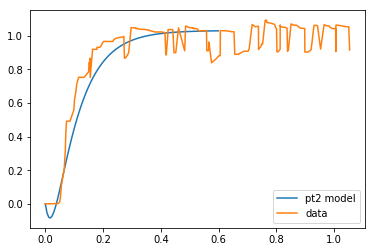

In [13]:
for i in range(0,len(MSE2)):
    if (MSE2[i] == min(MSE2)) & (MSE1[i] == min(MSE1)):
        if MSE2[i] < MSE1[i]:
            plt.plot(TO2[i],YOUTO2[i],label='pt2 model')
            plt.plot(T[i],YOUT[i],label='data')
            plt.legend()
            print('The best model is a pt2 system and is obtained from dataset:',i+1)
            print('Mean square error is:',MSE2[i])
            print('The state space parameters are:')
            print(SYS2[i])
        else:
            plt.plot(TO1[i],YOUTO1[i],label='pt2 model')
            plt.plot(T[i],YOUT[i],label='data')
            plt.legend()
            print('The best model is a pt1 system and is obtained from dataset:',i+1)
            print('Mean square error is:',MSE1[i])
            print('The state space parameters are:')
            print(SYS1[i])

In [14]:
print(time.localtime())

time.struct_time(tm_year=2017, tm_mon=11, tm_mday=17, tm_hour=12, tm_min=51, tm_sec=29, tm_wday=4, tm_yday=321, tm_isdst=0)
